# Reinfocement Learning.
## Q Learnimg.

We try to clear mountain car game of gym with minimun trials by using Q Learning.

## Detail os this game.

mountain carは坂を乗り越えるゲームで、取ることのできるアクションは右、左、操作なしの三つです。  
200回の操作の中で坂を上りきれたらクリアで、なるべく少ない回数でこれを達成しようというのがこの強化学習の目的です。  

強化学習には状態の情報と報酬を与え、与えられた環境での最適解を探索します。

## Reward.

報酬は各状態で-1を与え、総合値が少ない程良いです。



## Q Learning.

Q Learningを説明します。  
まず、状態空間を定義します。これは離散整数値の行列で、各状態に行動を割り当て、そこにQ値を格納します。

今回の場合、状態空間は（Position、Velosity、Action）の３次元空間で、各点に行動指標となるQ値を割り当てています。  
初期値はすべて0として、探索後にその点を更新する事を続けます。  

ゲームは200回の操作で成り立ち、それを指定epoch数繰り返してQテーブルを更新します。

## $\epsilon$ - Greedy.

探索の際、Qテーブルの値のみで探索をしてしまうと、探索可能範囲が限定されてしまいます。  
それを避けるために、ある確率（$\epsilon$）でランダムに行動するというのがこの手法です。  
これにより探索範囲が広くなりますが、この値が大きすぎると最適な行動をとることができなくなるため、探索範囲の拡大と最適性はトレードオフの関係にあると言えます。  
ある確率に対し、探索回数による減衰を与えるというモデルも存在します。


## Details of this algorithm.

### $Q(S_t,A_t) = Q(S_t,A_t) + \alpha \{R(S_t,A_t) + \gamma \max_{a \in A_{t+1}} Q(S_{t+1},a) - Q(S_t, A_t) )\}$


### $S_t$：現在の状態
### $A_t$：その時選択した行動
### $Q(S_t,A_t)$：状態$S_t$で行動$A_t$を取る場合の Qテーブルの値
### $R(S_t, A_t)$ : 行動後の報酬
### $\max_{a \in A_{t+1}} Q(S_{t+1},a)$ : 次に取りうる行動のうち、最大のQ値
### $\gamma$ : 重み
### $\alpha$ : 学習率

Qテーブルは０で初期化し、その後に下記探索を行う。  
自分が辿った状態空間（状態、行動）を上記のように随時更新していく。


## Exsample of execution.

In [91]:
# Import packages.
import gym
from gym import envs
import numpy as np

# Get status of observation.
def get_status(_observation):
    env_low = env.observation_space.low # 位置と速度の最小値
    env_high = env.observation_space.high #　位置と速度の最大値
    env_dx = (env_high - env_low) /100 # 40等分
    # 0〜39の離散値に変換する
    position = int((_observation[0] - env_low[0])/env_dx[0])
    velocity = int((_observation[1] - env_low[1])/env_dx[1])
    return position, velocity

# Update Q value.
def update_q_table(_q_table, _action,  _observation, _next_observation, _reward, _episode,
                    _iteration, _epoch):

    alpha = 0.3 + 0.3 * 0.98 ** (np.sqrt(_epoch))
    gamma = 0.99

    next_position, next_velocity = get_status(_next_observation)
    # print('_q_table_action', _q_table[next_position][next_velocity])
    next_max_q_value = max(_q_table[next_position][next_velocity])
    # print('next_max_qvalue', next_max_q_value)

    # 行動前の状態の行動価値 Q(s,a)
    position, velocity = get_status(_observation)
    q_value = _q_table[position][velocity][_action]
    # print('selected_action', _action)
    # print('previous_table', _q_table[position][velocity])
    # print('next_reward', _reward)

    # 行動価値関数の更新
    _q_table[position][velocity][_action] = q_value + alpha * (_reward + gamma * next_max_q_value - q_value)
    
    # print('renew q value', _q_table[position][velocity][_action])
    
    return _q_table

# Get action from Q table for training.
def get_action(_env, _q_table, _observation, _episode,_iteration, _epoch):
    epsilon = 0.0025
    if np.random.uniform(0, 1) > epsilon:
        position, velocity = get_status(observation)
        _action = np.argmax(_q_table[position][velocity])
    else:
        _action = np.random.choice([0, 1, 2])
    return _action

# Get action from Q table for testing.
def get_action0(_env, _q_table, _observation, _episode):
    position, velocity = get_status(observation)
    _action = np.argmax(_q_table[position][velocity])
    return _action

# Define environment.
env = gym.make('MountainCar-v0')
observation = env.reset()

q_table = np.zeros((100, 100, 3))
rewards = []
last_reward = 200

# Define list for visualize status space.
p_locus_ep = []
v_locus_ep = []
a_locus_ep = []

# Training.
for l, episode in enumerate(range(100000)):

    total_reward = 0
    observation = env.reset()
    p_locus_list = []
    v_locus_list = []
    a_locus_list = []

    for k, _ in enumerate(range(200)):
        p_locus, v_locus = get_status(observation)
        p_locus_list.append(p_locus)
        v_locus_list.append(v_locus)

        # ε-グリーディ法で行動を選択
        action = get_action(env, q_table, observation, episode, k, l)
        a_locus_list.append(action)

        # 車を動かし、観測結果・報酬・ゲーム終了FLG・詳細情報を取得
        next_observation, reward, done, _ = env.step(action)
        if (last_reward>199) & (k < 10):
            reward = reward + observation[1]*1

        #if (done==True) & (k+1<200) :
        #    reward = 150 * (0.998 ** k)        

        # Qテーブルの更新
        q_table = update_q_table(q_table, action, observation, next_observation, reward, episode, k, l)
        # total_reward +=  reward * (0.98 ** k)
        total_reward +=  reward

        observation = next_observation

        if done:
            last_reward = k+1
            p_locus_ep.append(p_locus_list)
            v_locus_ep.append(v_locus_list)
            a_locus_ep.append(a_locus_list)
            # doneがTrueになったら１エピソード終了
            if episode%1000 == 0:
                print('episode: {}, total_reward: {}'.format(episode, total_reward))
                print('clear iteration: {}'.format(k+1))
            rewards.append(total_reward)
            break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0, total_reward: -200.08094044937803
clear iteration: 200
episode: 1000, total_reward: -200.03741661550941
clear iteration: 200
episode: 2000, total_reward: -200.05331042878
clear iteration: 200
episode: 3000, total_reward: -166.0648184022215
clear iteration: 166
episode: 4000, total_reward: -200.0
clear iteration: 200
episode: 5000, total_reward: -161.0609705222496
clear iteration: 161
episode: 6000, total_reward: -200.0
clear iteration: 200
episode: 7000, total_reward: -195.95150718990575
clear iteration: 196
episode: 8000, total_reward: -200.0
clear iteration: 200
episode: 9000, total_reward: -200.0
clear iteration: 200
episode: 10000, total_reward: -200.0
clear iteration: 200
episode: 11000, total_reward: -198.93840546307126
clear iteration: 199
episode: 12000, total_reward: -197.0
clear iteration: 197
episode: 13000, total_reward: -158.0
clear iteration: 158
episode: 14000, 

In [95]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [93]:
def plot_locus(p_locus_ep, v_locus_ep, a_locus_ep, iteration_num):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot(p_locus_ep[iteration_num], v_locus_ep[iteration_num], a_locus_ep[iteration_num], "o-")
    ax.plot(p_locus_ep[iteration_num][-8:-1], v_locus_ep[iteration_num][-8:-1],
            a_locus_ep[iteration_num][-8:-1], "o", color='red')
    ax.plot(p_locus_ep[iteration_num][0:1], v_locus_ep[iteration_num][0:1], 
            a_locus_ep[iteration_num][0:1], "o", color='yellow')
    ax.set_xlabel("Position")
    ax.set_ylabel("Velosity")
    ax.set_zlabel("Action")
    plt.title('The locus of the state : Iteratuion number ' + str(iteration_num))

## The locus of training in status space. 

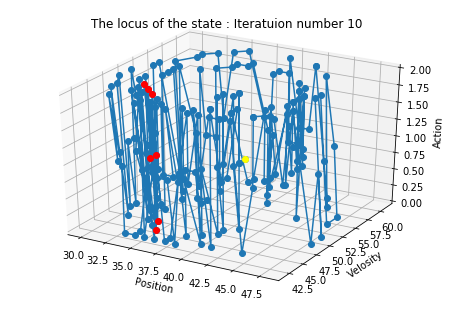

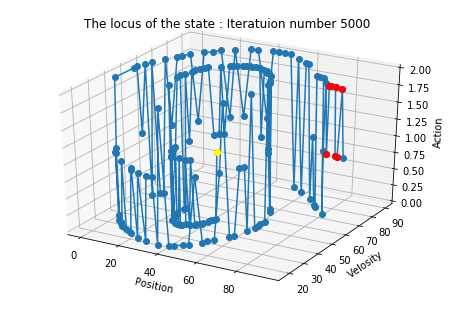

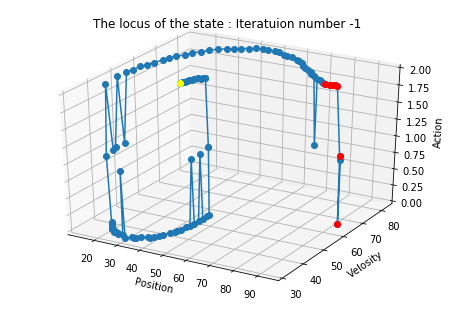

In [94]:
plot_locus(p_locus_ep, v_locus_ep, a_locus_ep, 10)
plot_locus(p_locus_ep, v_locus_ep, a_locus_ep, 5000)
plot_locus(p_locus_ep, v_locus_ep, a_locus_ep, -1)

十分な試行回数をこなせば、このように状態に応じて最適な行動をとるようになります。  

## Explosive increase of state space.

状態空間は入力情報を離散化した空間として与えるため、入力情報が増えるほど次元は増加します。  
また、取りうる行動に対してもそれは同様に起こります。  

これにより、状態空間の爆発的増加が発生し、現実的な範囲での探索は不可能となるという問題が発生します。  
これを解決しようという試みは、Q値を関数近似するという考えの下で行われてきました。  

その代表例として挙げられるのがDeep Q Learning(DQN)です。
DNNによりQ値を与える関数を近似することで、状態空間の爆発の影響を低減しています。
